###### KRATKI PREGLED KLJUČNIH ORGAZNIZACIJA I TIJELA U DOMENI GEOPROSTORNIH OBAVJEŠTAJNIH AKTIVNOSTI:
NGA (National Geospatial-Intelligence Agency)
- nacionalna geoprostorna-obavještajna (GEOINT) agencija SAD-a
- https://www.nga.mil/

GWG (Geospatial-Intelligence Working Group)
- radna skupina GEOINT zajednice SAD-a zadužena za razvoj i standardizaciju GEOINT-a 
- https://www.gwg.nga.mil/

MISB (Motion  Imagery  Standards  Board)
- organizacija (upravno tijelo) odgovorno za standardizaciju slikovnih zapisa s pokretnih platformi i njiima pripadajućih metapodataka
- https://www.gwg.nga.mil/misb/index.html
- javno dostupni standardi MISB-a: https://www.gwg.nga.mil/misb/st_pubs.html
- MISB metapodaci besposadnih zrakoplovnih sustava: https://gwg.nga.mil/misb/docs/standards/ST0601.6.pdf 

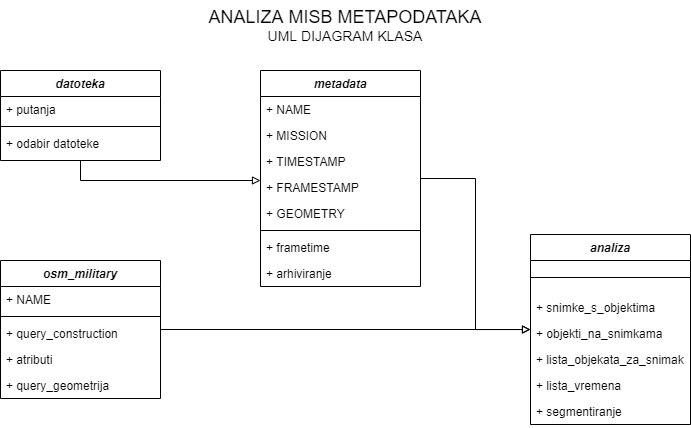
Napomena: Unatoč tome što sam kod nije pisan na objekto-orijentiran način moguće ga je tako promatrati.

# Analiza MISB metapodataka
### U ovom "notebook"-u biti će prezentirana Python skripta koja omogućava:
##### - izradu geoprostorne arhive snimaka besposadnih zrakoplovnih sustava usuglašenih s MISB standardom
##### - dohvaćanje podataka o vojnim objektima s OpenStreetMap-a
##### - prostornu analizu arhiviranih snimaka i dohvaćenih vojnih objekata u cilju detekcije onih snimaka na kojima su snimljeni vojni objekti te prikaz vremena u kojem ih se može vidjeti na pojedinoj snimki

### Notebook je koncipiran na način da u prvom bloku daje pisano objašenjenje određenog dijela koda te korištenih modula i funkcija, a u sljedećem bloku je ispisan sam kod.

## Python skripta: MISB_Metadata.py

### 1.) Instalacija i učitavanje potrebnih modula:
- pandas - modul za analitičku obradu podataka
- geopandas - modul za analitičku obradu geoprostornih podataka
- shapely - modul za stvaranje, upravljanje i analizu geometrijskih objekata
- datetime - modul za upravljanje zapisima datuma i vremena
- os - modul za upravljanje funkcionalnostima operativnog sustava
- sys - modul za dohvaćanje varijabli i funkcija intepretera skripte
- OSMPythonTools:
    - Api - pristup za službeni API OpenStreetMap-a
    - Nominatim - alat za (obrnuto) geokodiranje podataka OpenStreetMap-a
    - Overpass - API za pretraživanje i dohvaćanje podataka OpenStreetMap-a
    - overpassQueryBuilder - modul za pretvaranje upita u OverpassQL (Overpass upitni jezik)

In [ ]:
!pip install pandas==1.0.3 # U zadanoj instalaciji je starija verzija 0.23.0 koja je nekompatibilna s drugim modulima
!pip install geopandas
!pip install shapely
!pip install OSMPythonTools

In [ ]:
import pandas
import geopandas
import shapely
from shapely.geometry import Polygon
from shapely.geometry import shape
from datetime import datetime,timedelta
import os
import sys
from OSMPythonTools.api import Api
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder,Overpass

##### Metapodaci letjelice komprimirani su unutar video datoteke u zasebnom kanalu, a zapisani su u tzv. KLV formatu (Key-Length-Value) te ih je prethodno potrebno "dekodirati" i zapisati u neki općenito prihvatljiviji format, a to najčešće bude u obliku .csv datoteke.
(U svrhu testiranja "dekodiranje" i zapisivanje .csv datoteke s MISB metapodacima je prethono odrađeno pomoću programa ArcGIS Pro i ekstenzije Image Analyst | Full Motion Video) <br>
Primjer metapodataka se nalazi u folderu Metapodaci ovog Microsoft Auzre Notebooks projekta ("/home/nbuser/library/Metapodaci").

### 2.) Učitavanje metapodataka iz .csv datoteka i izrada geoprostorne arhive
Opis definiranih funkcija:
  - odabir_datoteke () - funkcija kojom se od korisnika traži odabir željenih .csv datoteka unutar radnog direktorija, a povratno vraća listu s nazivima odabranih dateoteka

In [ ]:
def odabir_datoteke():
    print("ODABERITE .CSV DATOTEKU")
    files=[]
    selection=[]
    i=0
    for file_name in os.listdir(os.getcwd()):
        if file_name.endswith('.csv') or file_name.endswith('.CSV'):
            print(str(i)+" --> "+str(file_name))
            files.append(file_name)
            i=i+1
    if i==0:
        print("NEMA .CSV DATOTEKA")
        sys.exit()
    print(str(i)+" --> "+"SVE .CSV DATOTEKE")
    print("(U slučaju višestrukog izbora odabir odvojite zarezom --> 0,1,2,3...)")
    file_number=input("---> ")
    if file_number==str(i):
        print("ODABRALI STE SVE .CSV DATOETEKE")
        selection=files
    else:
        file_nmbs=file_number.split(",")
        int_file_nmbs=[]
        for j in range(0,len(file_nmbs)):
            int_file_nmb=int(file_nmbs[j])
            if int_file_nmb not in range(0,i+1):
                print(str(int_file_nmb)+"--> POGREŠAN BROJ DATOTEKE")
            else:
                int_file_nmbs.append(int_file_nmb)
        print("Odabrano je: ")
        for ime in range(0,len(int_file_nmbs)):
            print(files[int_file_nmbs[ime]])
            selection.append(files[int_file_nmbs[ime]])
    return selection

  - frametime (dataframe,TIME_COL) - funkcija kojom se računa ukupno vrijeme trajana snimke, vrijeme trajanja pojedinog "frame-a" i ukupan broj "frame-ova" iz skupa podataka nastalog učitavanjem datoteke metapodataka i sukladno definiranom polju vremena

In [ ]:
def frametime(dataframe,TIME_COL):
        start=dataframe.loc[0,TIME_COL]
        start_time=start[11:(len(start)-1)]
        end=dataframe.loc[((len(dataframe))-1),TIME_COL]
        end_time=end[11:(len(start)-1)]
        time_delta=datetime.strptime(end_time,"%H:%M:%S.%f")-datetime.strptime(start_time,"%H:%M:%S.%f")
        frame_time=time_delta/len(dataframe)
        print("Trajanje snimke: "+str(time_delta))
        print("Trajanje frame-a: "+str(frame_time))
        print("Broj frame-ova: "+str(len(df)))
        return frame_time

  - arhiviranje (gpkg_path,frames_gdf,lista_datoteka,datoteka_iz_liste) - funkcija kojom se sukladno danoj putanji skup prostronih podataka nastao iz učitane datoteke metapodataka pohranjuje u novu ili postojeću geoprostornu arhivu te se ispisuje status o broju arhiviranih snimaka iz liste odabranih datoteka i njihovih naziva

In [ ]:
def arhiviranje(gpkg_path,frames_gdf,lista_datoteka,datoteka_iz_liste):
        gpkg_check=os.path.exists(gpkg_path)
        if gpkg_check is True:
            print("USPJEŠNO PRONAĐENA POSTOJEĆA GPKG ARHIVA")
            Frames=geopandas.read_file("MISB_MetadataDB.gpkg",layer="Frames",driver="GPKG")
            print(Frames)
            update_Frames=geopandas.GeoDataFrame(pandas.concat([Frames,frames_gdf],ignore_index=True),crs="EPSG:4326")
            update_Frames.to_file("MISB_MetadataDB.gpkg",layer="Frames",driver="GPKG")
            print(update_Frames)
            print("ARHIVA JE AŽURIRANA")
            print("STATUS: "+str(lista_datoteka.index(datoteka_iz_liste)+1)+"/"+str(len(lista_datoteka)))
        else:
            print(frames_gdf)
            frames_gdf.to_file("MISB_MetadataDB.gpkg",layer="Frames",driver="GPKG")
            print("STVORENA JE NOVA GPKG ARHIVA")
            print("STATUS: "+str(lista_datoteka.index(datoteka_iz_liste)+1)+"/"+str(len(lista_datoteka)))

Pomoću modula "os" ispisuje se radni direktorij i traži od korisnika potvrda ili promjena istog:

In [ ]:
print(os.getcwd())
print("POTVRDITE DA JE OVO VAŠ RADNI DIREKTORIJ: "+os.getcwd())
print("0 - NE \n1 - DA")
unos=int(input("--> "))

Ovisno o prethodnom unosu korisnika poziva se funkcija za odabir datoteka u postojećem ili novoodabranom radnom direktoriju:

(Napomena: Primjer metapodataka se nalazi u "cloud-u" na sljedećoj putanji: "/home/nbuser/library/Metapodaci")

In [ ]:
if unos==0:
    print("UNESITE ISPRAVNU PUTANJU VAŠEG RADNOG DIREKTORIJA: \n>>> Napomena: Putanja ne smije završavati s znakom '\\' <<<)")
    novi_cwd=input("--> ")
    os.chdir(novi_cwd)
    print("NOVI RADNI DIREKTORIJ JE: "+os.getcwd())
    ime_datoteke=odabir_datoteke()
elif unos==1:
    ime_datoteke=odabir_datoteke()
else: print("NISTE UNIJELI ODGOVARAJUĆI BROJ")

Pomoću modula "pandas" čitaju se prethodno odabrane .csv datoteke i definiraju se za analizu ključna polja u metapodacima kao što su naziv misije, koordinate okvira snimke te vrijeme i datum snimke. Nad definiranim poljima se vrši tzv. primarna obrada podataka koja podrazumijeva strukturiranje podataka u odgovarajuće tipove kako bi se mogla provesti daljnja analiza.

Za svaku datoteku poziva se funkcija "frametime" koja pomoću polja vremena i datuma računa ukupno trajanje snimke, broj "frame"-ova snimke i trajanje pojedinog "frame"-a snimke, a za navedeno se koristi "datetime" modul koji podržava vremenske računske operacije i omogućava pretvorbu string tipova podataka u datetime tip podataka pomoću funkcija "strftime" i "strptime".

Pomoću modula "geopandas" stvara se prostorni skup podataka u kojem je za svaki "frame" pojedine snimke izračunata njegova geometrija iz koordinata okvira snimke, međutim zapisi koordinata mogu sadržavati pogreške zbog kojih geometrija "frame"-a ne tvori poligon pa se takvi rezultati izbacuju iz skupa i vodi se njihova statistika. 
Također je svakom "frame"-u pojedine snimke pridruženo njegovo vrijeme pojavljivanja unutar snimke iz prethodno izračunatog broja "frame-ova" i trajanja "frame"-ova.

Opisani prostorni skup podataka koji sadrži ključne metapodatke svakog "frame"-a pojedine snimke se u konačnici pohranjuje pozivanjem funkcije "arhiviranje" pri čemu se stvara nova ili ažurira postojeća geoprostorna arhiva formata .gpkg (GeoPackage). GeoPackage je OGC (Open Geospatial Constortium) geoinformacijski standard koji se može tumačiti kao SQLite prostorna baza podataka.

In [ ]:
for files in ime_datoteke:
    if os.getcwd().startswith('/'):
        FILE_NAME=os.getcwd()+"/"+files
    else:
        FILE_NAME=os.getcwd()+"\\"+files                    
    df=pandas.read_csv(FILE_NAME)
    MISSION_COL="Mission ID"
    TIME_FORMAT="%H:%M:%S.%f"
    if set(["UNIX Time Stamp"]).issubset(df.columns):
        TIME_COL="UNIX Time Stamp"
        LONG_COLS=["Corner Longitude Point 4","Corner Longitude Point 3","Corner Longitude Point 2","Corner Longitude Point 1"]
        LAT_COLS=["Corner Latitude Point 4","Corner Latitude Point 3","Corner Latitude Point 2","Corner Latitude Point 1"]
    elif set(["Precision Time Stamp"]).issubset(df.columns):
        TIME_COL="Precision Time Stamp"
        for time in range(0,len(df)):
            timestamp_df=str(df.loc[time,TIME_COL])
            timestamp_slice=timestamp_df[0:10]+"."+timestamp_df[11:]
            timestamp_float=float(timestamp_slice)
            timestamp=datetime.fromtimestamp(timestamp_float)
            df.loc[time,TIME_COL]=datetime.strftime(timestamp,"%Y-%m-%d %H:%M:%S.%f")+"Z"
        LONG_COLS=["Offset Corner Longitude Point 4","Offset Corner Longitude Point 3","Offset Corner Longitude Point 2","Offset Corner Longitude Point 1"]
        LAT_COLS=["Offset Corner Latitude Point 4","Offset Corner Latitude Point 3","Offset Corner Latitude Point 2","Offset Corner Latitude Point 1"]
    else:
        print("NE POSTOJI ODGOVARAJUĆA KOLONA VREMENA")

    frame_time=frametime(df,TIME_COL)

    frames_gdf=geopandas.GeoDataFrame(data=None,columns=['Naziv snimke','Naziv misije','Datum i vrijeme','Vrijeme frame-a','geometry'],crs="EPSG:4326")
    vrijeme_frame=[]
    naziv_snimke=[]
    invalid_geom=[]

    for frame in range(0,len(df)):
        poligon=[]
        for i in range(0,4):
            x=df.loc[frame,LONG_COLS[i]]
            y=df.loc[frame,LAT_COLS[i]]
            koordinate=(x,y)
            poligon.append(koordinate)
        naziv_snimke.append(files.replace(".csv","").replace(".CSV","").replace("VideoMetadataToFeatureClass_CsvFile__",""))
        frames_gdf.loc[frame,'Naziv snimke']=naziv_snimke[frame]
        frames_gdf.loc[frame,'Naziv misije']=df.loc[frame,MISSION_COL]
        frames_gdf.loc[frame,'Datum i vrijeme']=df.loc[frame,TIME_COL]
        vrijeme_frame.append(str(frame_time*(frame+1)))
        frames_gdf.loc[frame,'Vrijeme frame-a']=vrijeme_frame[frame]
        try:
            geometrija=Polygon(poligon)
            frames_gdf.loc[frame,'geometry']=geometrija
        except ValueError:
            frames_gdf.loc[frame,'geometry']=None
            invalid_geom.append(frame)
            print("Frame broj "+str(frame)+" nema ispravnu geometriju")

    frames_gdf=frames_gdf.drop(invalid_geom).reset_index(drop=True)
    print("Broj obrađenih frame-ova: "+str(len(frames_gdf)))
    print("Broj neupotrebljivih frame-ova "+str(len(df)-len(frames_gdf)))
    
    if os.getcwd().startswith('/'):
        gpkg_path=os.getcwd()+"/"+"MISB_MetadataDB.gpkg"
    else:
        gpkg_path=os.getcwd()+"\\"+"MISB_MetadataDB.gpkg"      
    
    arhiviranje(gpkg_path,frames_gdf,ime_datoteke,files)

### 3.) Pretraživanje vojnih objekata i dohvaćanje njihove geometrije i atributa
Opis definiranih funkcija:
  - query_construction(search_area) - funkcija koja objedinjuje OSMPythonTools module i služi za dohvaćanje vojnih objekata s OpenStreetMap-a nad željenim područjem te ispisuje broj dohvaćenih rezultata <br>(koristi modul "Nominatim" za formiranje OSM sintakse željenog područja, modul "overpassQueryBuilder" za formiranje upita kojim se traže svi "military" i "landuse:military" objekti te modul "Overpass" za dohvaćanje rezultata tako formiranih upita)

In [ ]:
def query_construction(search_area):
        nominatim_query=Nominatim().query(search_area)
        query_01=overpassQueryBuilder(area=nominatim_query.areaId(),elementType=['node','way','relation'], selector=["military"],includeGeometry=True)
        query_02=overpassQueryBuilder(area=nominatim_query.areaId(),elementType=['node','way','relation'], selector='"landuse"="military"',includeGeometry=True)
        result_01=Overpass().query(query_01)
        result_02=Overpass().query(query_02)
        print("Pronađeno ukupno "+str(result_01.countElements())+" 'military' objekta")
        print("Pronađeno ukupno "+str(result_02.countElements())+" 'landuse=military' objekta")
        results=[result_01,result_02]
        return results

  - atributi(query_result,atribut) - funkcija koja služi za čitanje vrijednosti specifično traženih atributa iz rezultata pretraživanja OSM podataka dobivenih pomoću Overpass modula

In [ ]:
def atributi(query_result,atribut):
    opis=[]
    for i in range(0,query_result.countElements()):
        tagovi=query_result.elements()[i].tags()
        if atribut in tagovi:
            description=tagovi.get(atribut)
            opis.append(description)
        else: opis.append(None)
    return opis

  - query_geometrija(query_result) - funkcija koja služi za pohranu WKT geometrije iz rezultata pretraživanja OSM podataka dobivenih pomoću Overpass modula

In [ ]:
def query_geometrija(query_result):
    geometry=[]
    for i in range(0,query_result.countElements()):
        geometrija=shape(query_result.elements()[i].geometry())
        geometry.append(geometrija.wkt)
    return geometry

Poziva se funkcija "query_construction" kojom se dohvaćaju svi vojni objekti nad područjem Republike Hrvatske i ispisuje broj dobivenih rezultata.<br>
(U pozadini se pomooću modula "Nominatim" dohvaća OSM sintaksa za podrčuje Republike Hrvatske, pomoću modula "overpassQueryBuilder" definiraju se dva upita kojima se na području RH traže svi tipovi OSM podataka koji sadrže atribut "military" ili atribut "landuse=military" i pomoću modula "Overpass" dohvaćaju se s OSM-a rezultati tako formiranih upita.)

In [ ]:
results=query_construction("Croatia")

Pomoću modula "geopandas" stvara se novi prazan prostorni skup podataka koji će se kasnije popuniti prethodno dobivenim rezultatima, međutim spremati će se samo oni atributi koji su prepoznati kao bitni pri inicijalnom pregledu rezultata tj. za koje su definirana polja u prostornom skupu podataka.

In [ ]:
columns=["name","old_name","alt_name","military","description",'location']
gdf=geopandas.GeoDataFrame(data=None,columns=(columns+["geometry"]),crs="EPSG:4326")

Nad rezultatima postavljenih upita poziva se funkcija za pohranu geometrije i po svakom prethodno definiranom polju poziva se funkcija za čitanje vrijednosti atributa te se iste spremaju u novostvoreni prostorni skup podataka. Na kraju se izbacuju rezultati koji su identični u oba upita i ispisuje se statistika rezultata.

In [ ]:
for res in results:
    lim=len(gdf)
    for cols in columns:
        lim_v=0+lim
        for i in atributi(res,cols):
            gdf.loc[lim_v,cols]=i
            lim_v=lim_v+1
    for geom in query_geometrija(res):
        gdf.loc[lim,'geometry']=shapely.wkt.loads(geom)
        lim=lim+1
gdf_clean=gdf.drop_duplicates().reset_index(drop=True)
print("Unutar pronađenih rezultata obrisano je "+str((len(gdf)-len(gdf_clean)))+" duplikata.")
print("Pronađeno je "+str((len(gdf)-(len(gdf)-len(gdf_clean))))+" različitih 'military'/'landuse:military' objekta")

Kako bi se olakšala daljnja analiza svakom pronađenom vojnom objektu koji nema vrijednosti u polju imena dodjeljuje se novo specifično ime i ispisuje se tako ispunjeni prostorni skup podataka.

In [ ]:
for obj in range(0,len(gdf_clean)):
    if gdf_clean.loc[obj,'name']==None:
        gdf_clean.loc[obj,'name']="UNK_Obj_"+str(obj)
print(gdf_clean)

### 4.) Prostorna analiza podataka i spremanje dobivenih rezultata
Cilj prostorne analize je dati odgovor na sljedeće pitanje:
- Nalaze li se na arhiviranim snimkama vojni objekti?

Potvrdan odgovor na to pitanje bi trebao osigurati rezultate na temelju kojih se dodatnom raščlambom može odgovoriti na sljedeća potpitanja:
- Koji su to objekti? 
- Na kojim snimkama su vidljivi?
- U kojem vremenu pojedine snimke je pojedini objekt vidljiv?

Pomoću modula "geopandas" čitaju se i ispisuju metapodaci snimaka iz geoprostorne arhive. 

In [ ]:
Frames=geopandas.read_file("MISB_MetadataDB.gpkg",layer="Frames",driver="GPKG")
print(Frames)

Pomoću modula "pandas" otvara se novi skup podataka u koji će se spremati rezultati prostorne analize. Novi skup podataka će sadržavati već prethodno definirana polja vojnih objekata uz informaciju o nazivu snimke, datumu i vremenu snimke i vremenu "frame"-a ako se taj vojni objekt u istom nalazi. 

In [ ]:
analysis_df=pandas.DataFrame(data=None,columns=(columns+["Vrijeme frame-a"]+["Naziv snimke"]+["Datum i vrijeme"]))

Prostorna analiza svodi se na ispitivanje prostornog preklapanja između pojedinog "frame"-a svake snimke i pojedinog vojnog objekta, a vrši se pomoću metode "intersects" iz modula "shapely".
Rezultati provedene analize tj. svi "frame"-ovi čije se geometrije sijeku s geometrijama pojedinih vojnih objekata spremaju se u novostvoreni skup podataka.

In [ ]:
for military in range(0,len(gdf_clean)):
    for frames in range(0,len(Frames)):
        if gdf_clean.loc[military,'geometry'].intersects(Frames.loc[frames,'geometry']):
            analysis_df.loc[frames,columns]=gdf_clean.loc[military,:'geometry']
            analysis_df.loc[frames,'Vrijeme frame-a']=Frames.loc[frames,'Vrijeme frame-a']
            analysis_df.loc[frames,'Naziv snimke']=Frames.loc[frames,'Naziv snimke']
            analysis_df.loc[frames,'Datum i vrijeme']=Frames.loc[frames,'Datum i vrijeme']
        else:
            continue

Rezultati spremljeni u skupu podataka se ispisuju i pohranjuju u .csv datoteku u radnom direktoriju.

In [ ]:
print(analysis_df)
analysis_df.to_csv("SpatialAnalysis.csv")
print("REZULTATI ANALIZE SPREMLJENI U RADNOM DIREKTORIJU --> 'SpatialAnalysis.csv'")

### 5.) Raščlamba rezultata prostorne analize podataka
Opis definiranih funkcija:
  - snimke_s_objektima(dataframe) - funkcija koja na temelju skupa podataka s rezultatima prostorne analize ispisuje snimke i broj snimaka na kojima se nalaze vojni objekti te vraća listu tih snimaka

In [ ]:
def snimke_s_objektima(dataframe):
        snimke=dataframe["Naziv snimke"].unique()
        print("Snimke na kojima su vidljivi vojni objekti:")
        for s in snimke:
            print(" --> "+s)
        print("Ukupno: "+str(len(snimke)))
        return snimke

  - objekti_na_snimkama(dataframe) - funkcija koja na temelju skupa podataka s rezultatima prostorne analize ispisuje vojne objekte i broj vojnih objekata koji se nalaze na snimkama i vraća listu tih objekata

In [ ]:
def objekti_na_snimkama(dataframe):
        mil_obj=dataframe["name"].unique()
        print("Vojni objekti koji su vidljivi na snimkama:")
        for o in mil_obj:
            print(" --> "+o)
        print("Ukupno: "+str(len(mil_obj)))
        return mil_obj

  - lista_objekata_za_snimak(dataframe,snimak) - funkcija koja vraća listu vojnih objekata koji se nalaze u traženom snimku na temelju skupa podataka koji sadrži rezultate prostorne analize 

In [ ]:
def lista_objekata_za_snimak(dataframe,snimak):
    mil_obj=dataframe["name"].unique()
    n_obj=[]
    for obj in mil_obj:
        for i in range(0,len(dataframe)):
            if dataframe.loc[i,"Naziv snimke"]==snimak and dataframe.loc[i,"name"]==obj:
                    n_obj.append(obj)
    objekti=[]
    for j in set(n_obj):
        objekti.append(j)
    return objekti

  - lista_vremena(dataframe,snimak,objekt) - funkcija koja vraća listu vremena svih "frame"-ova u kojima se nalazi traženi vojni objekt u traženom snimku na temelju skupa podataka koji sadrži rezultate prostorne analize

In [ ]:
def lista_vremena(dataframe,snimak,objekt):
    t_obj=[]
    for i in range(0,len(dataframe)):
        if dataframe.loc[i,"Naziv snimke"]==snimak and dataframe.loc[i,"name"]==objekt:
                t_obj.append(df.loc[i,"Vrijeme frame-a"])
    return t_obj

  - segmetiranje(time_list) - funkcija koja sortira listu vremena nekog vojnog objekta i vraća pravilne segmente tj. intervale pojavljivanja uz kriterij da pojedini vremenski zapisi unutar segmenata nisu u vremenskom razmaku većem od sekunde odnosno svaki novi segment tj. interval pojavljivanja se stvara ukoliko vremenski razmak pojedinih vremenskih zapisa bude veći od sekudne

In [ ]:
def segmentiranje(time_list):
    TIME_FORMAT="%H:%M:%S.%f"
    step=timedelta(seconds=1)
    unsorted_timelist=[]
    timetable=[]
    for t in range(0,len(time_list)):
        unsorted_timelist.append(datetime.strptime(time_list[t],TIME_FORMAT))
    timelist=sorted(unsorted_timelist)
    for time in range(1,len(timelist)):
        current_frame=timelist[(time-1)]
        next_frame=timelist[time]
        delta=next_frame-current_frame
        if delta>step:
            segment_endtime=current_frame
            segment_starttime=next_frame
            timetable.append(segment_endtime)
            timetable.append(segment_starttime)
        else: continue
    if len(timetable)!=0:
        timetable.insert(0,timelist[0])
        timetable.insert(len(timetable),timelist[(len(timelist))-1])
        for dt in range(0,len(timetable)):
            timetable[dt]=datetime.strftime(timetable[dt],TIME_FORMAT)
    elif len(timetable)==0:
        timetable.append(timelist[0])
        timetable.append(timelist[-1])
        for dt in range(0,len(timetable)):
            timetable[dt]=datetime.strftime(timetable[dt],TIME_FORMAT)
    parovi=[]
    if len(timetable)%2 == 0:
        for i in range(0,len(timetable),2):
            parovi.append("("+timetable[i]+" - "+timetable[i+1]+")")
    return parovi

Pomoću modula "pandas" čitaju se spremljeni rezultati prostorne analize iz .csv datoteke.

In [ ]:
df=pandas.read_csv("SpatialAnalysis.csv")

Poziva se funkcija "snimke_s_objektima" kako bi se dobile jedinstvene vrijednosti naziva snimke iz datoteke s rezultatima prostorne analize te njihov ukupan zbroj što odgovara na pitanje:
 - Na kojim snimkama (i na koliko snimaka) su snimljeni vojni objekti?

In [ ]:
snimke=snimke_s_objektima(df)

Poziva se funkcija "objekti_na_snimkama" kako bi se dobile jedinstvene vrijednosti naziva vojnih objekata iz datoteke s rezultatima prostorne analize te njihov ukupan zbroj što odgovara na pitanje:
- Koji su vojni objekti (i koliko je vojnih objekata) snimljeni na snimkama?

In [ ]:
objekti=objekti_na_snimkama(df)

Za svaku snimku iz datoteke s rezultatima prostorne analize poziva se funkcija za izradu liste vojnih objekata za snimak i ispisuju se svi vojni objekti snimljeni u pojedinoj snimki, a potom se za svaki vojni objekt koji se nalazi u pojedinoj snimki poziva funkcija za izradu liste vremenskih zapisa pojavljivanja tog objekta. Lista vremenskih zapisa vojnih objekata se prosljeđuje funkciji segmentiranja kako bi se u konačnici mogli ispisati svi vojni objekti sadržani u pojedinom snimku zajedno s vremenskim intervalima u kojima se na istima pojavljuju i ukupan zbroj objekata sadržanih u pojedinoj snimki.

In [ ]:
for snimak in snimke:
    print("Snimka "+str(snimak)+" sadrži sljedeće vojne objekte u navedenom vremenu:")
    vojni_objekti=lista_objekata_za_snimak(df,snimak)
    for obj in vojni_objekti:
        print("--> "+obj)
        time_list=lista_vremena(df,snimak,obj)
        video_time=segmentiranje(time_list)
        for vt in video_time:
            print(vt)
    print("Ukupno: "+str(len(vojni_objekti)))
    print("************")